# Delta Robot Kinematics, Configuration Space, Workspace and Singularity Analysis

## Degrees of Freedom

The delta robot has 3 degrees of freedom. The 3 degrees of freedom are the 3 angles of the 3 arms. The 3 angles are the angles between the arms and the base. The 3 angles are denoted by $\theta_1$, $\theta_2$, and $\theta_3$. The 3 angles are the joint angles of the delta robot. The 3 angles are the configuration space of the delta robot. The configuration space of the delta robot is the space of all possible joint angles of the delta robot. The configuration space of the delta robot is a 3-dimensional space. The configuration space of the delta robot is a 3-dimensional space because the delta robot has 3 degrees of freedom.

<div style="text-align: center;">
  <img src="images/delta_robot_modern_robotics.png" alt="Delta Robot">
</div>

# Configuration Space

The delta robot's configuration space is bound by the 3 motor angles $\theta_1$, $\theta_2$, and $\theta_3$. The configuration space is a 3D space, where each point in the space corresponds to a unique position of the robot's end effector.

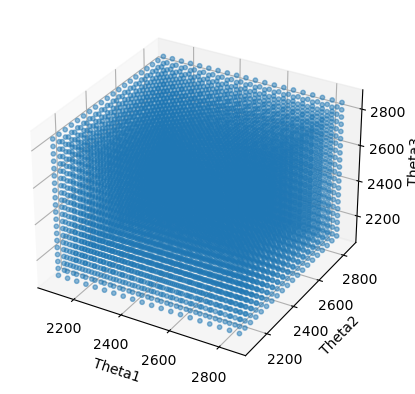

In [14]:
# The C-Space for the delta robot is 3 dimensional for the 3 motors
import numpy as np
import matplotlib.pyplot as plt

# Motor ranges in Dynamixel steps
theta1_range = [2100, 2850]
theta2_range = [2100, 2850]
theta3_range = [2100, 2850]

# Use a smaller number of points for a scatter plot to keep rendering fast
num_points = 20
theta1 = np.linspace(theta1_range[0], theta1_range[1], num_points)
theta2 = np.linspace(theta2_range[0], theta2_range[1], num_points)
theta3 = np.linspace(theta3_range[0], theta3_range[1], num_points)
Theta1, Theta2, Theta3 = np.meshgrid(theta1, theta2, theta3)

# Create a 3D scatter plot of the configuration space points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Theta1.flatten(), Theta2.flatten(),
           Theta3.flatten(), alpha=0.5, s=10)

# Set the labels
ax.set_xlabel('Theta1')
ax.set_ylabel('Theta2')
ax.set_zlabel('Theta3')

# Show the plot
plt.show()

In [16]:
# Robot Constants
sqrt3 = np.sqrt(3)
SB = 180  # Base Equilateral Triangle Side Length [mm]
SP = 80  # Platform Equilateral Triangle Side Length [mm]
L = 120  # Active Link Length [mm]
ell = 125  # Passive Link Length [mm]
h = 25  # Passive Link Width [mm]
WB = (sqrt3 / 6) * SB
UB = (sqrt3 / 3) * SB
WP = (sqrt3 / 6) * SP
UP = (sqrt3 / 3) * SP

# Inverse Kinematics
https://people.ohio.edu/williams/html/PDF/DeltaKin.pdf

In [17]:
# The analytical solution for IK uses the constraint equations found from the vector-loop closure equations
# E_i * cos(theta_i) + F_i *  sin(theta_i) + G_i = 0

# Variables obtained from the Vector-Loop Closure Equations
a = WB - UP
b = (SP / 2) - (sqrt3 / 2) * WP
c = WP - (WB / 2)

def IK(x,y,z):
  E = (
    2*L*(y+a), # E1
    -L*(sqrt3*(x+b)+y+c), # E2
    L*(sqrt3*(x-b)-y-c) #E3
    )
  F = (
    2*z*ell, # F1
    2*z*ell,  # F2
    2*z*ell,  # F3
  )
  G = (
    x**2 + y**2 + z**2 + a**2 + L**2 + 2*y*a - ell**2, # G1
    x**2 + y**2 + z**2 + b**2 + c**2 + L**2 + 2*(x*b+y*c) - ell**2,  # G2
    x**2 + y**2 + z**2 + b**2 + c**2 + L**2 + 2*(-x*b+y*c) - ell**2,  # G3
  )
  thetas = []
  # Tangent Half-Angle Substitution
  for i in range(3):
    t_plus = (-F[i] + np.sqrt(E[i]**2 + F[i]**2 - G[i]**2)) / (G[i] - E[i])
    t_minus = (-F[i] - np.sqrt(E[i]**2 + F[i]**2 - G[i]**2)) / (G[i] - E[i])
    theta_plus = 2 * np.arctan(t_plus)
    theta_minus = 2 * np.arctan(t_minus)
    thetas.append((theta_plus, theta_minus))
  return thetas # [rad]

# Some Test Cases
print(IK(0,0,-80))

[(2.947955376298519, 0.33198027571561306), (2.675530724274102, 0.08952358182496205), (2.675530724274102, 0.08952358182496205)]


/tmp/ipykernel_162192/2203303403.py:28: RuntimeWarning: invalid value encountered in sqrt
  t_plus = (-F[i] + np.sqrt(E[i]**2 + F[i]**2 - G[i]**2)) / (G[i] - E[i])
/tmp/ipykernel_162192/2203303403.py:29: RuntimeWarning: invalid value encountered in sqrt
  t_minus = (-F[i] - np.sqrt(E[i]**2 + F[i]**2 - G[i]**2)) / (G[i] - E[i])


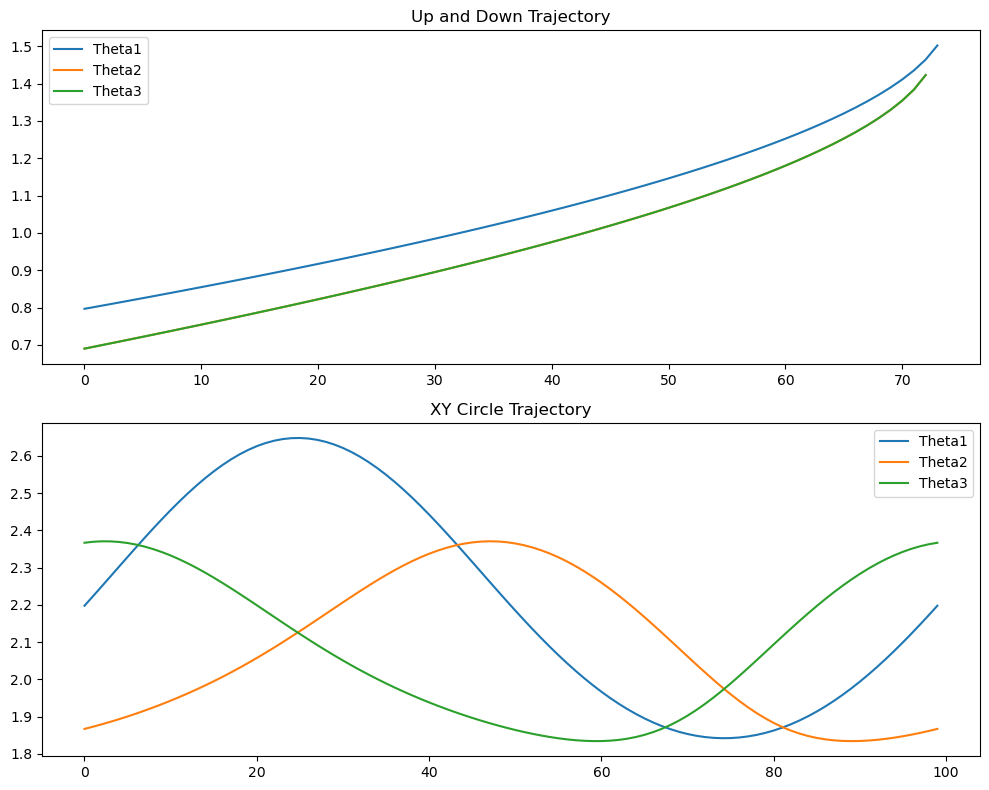

In [25]:
# Plot a simple up and down trajectory
up_and_down = np.linspace(-180, -280, 100)
x = np.zeros(len(up_and_down))
y = np.zeros(len(up_and_down))
z = up_and_down
thetas = np.array([IK(x,y,z) for x,y,z in zip(x,y,z)])

# Trajectory: An XY Circle with a center of (0, 0, -200) mm and a radius of 50 mm
# At the same time, the Z displacement goes through 2 cycles of a sine wave
# centered on Z = -200 mm with an amplitude of 25 mm
t = np.linspace(0, 2*np.pi, 100)
x = 50 * np.cos(t)
y = 50 * np.sin(t)
z = -200 + 25 * np.sin(t)
thetas_circle = np.array([IK(x,y,z) for x,y,z in zip(x,y,z)])

# Plot the trajectories
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the up and down trajectory
axs[0].plot(thetas[:,0,1], label='Theta1')
axs[0].plot(thetas[:,1,1], label='Theta2')
axs[0].plot(thetas[:,2,1], label='Theta3')
axs[0].set_title('Up and Down Trajectory')
axs[0].legend()

# Plot the XY circle trajectory
axs[1].plot(thetas_circle[:,0,0], label='Theta1')
axs[1].plot(thetas_circle[:,1,0], label='Theta2')
axs[1].plot(thetas_circle[:,2,0], label='Theta3')
axs[1].set_title('XY Circle Trajectory')
axs[1].legend()

plt.tight_layout()
plt.show()

# Forward Kinematics


In [ ]:
def FK(th1,th2,th3):
  pass

# Plotting the Robot's Configuration

In order to better visualize the robot's configuration, we can plot the robot's links and joints in 3D space.

In [ ]:
def knee_joints(theta1,theta2,theta3):
  knee_1 = (0, -WB-L*np.cos(theta1), -L*np.sin(theta1))
  knee_2 = ((sqrt3/2)*(WB+L*np.cos(theta2)), (1/2)*(WB+L*np.cos(theta2)), -L*np.sin(theta2))
  knee_3 = ((-sqrt3/2)*(WB+L*np.cos(theta3)), (1/2)*(WB+L*np.cos(theta3)), -L*np.sin(theta3))
  return (knee_1, knee_2, knee_3)